> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

## Multivariate Input ,Univariate Output CNN ,Single Step
This tutorial is to demonstrate the process in build CNN for Multivariate Input, Univariate Output  for Single Step. It consists of 2 major part which are :

The Demostration of Building CNN using Synthetic data and Exercise of building CNN using Daily_Demand_Forecasting_Order data. First, we will show the step in building the CNN :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data) Step 2. Model Configuration for CNN
Step 3. Train the model
Step 4. Validate the model using graph
Step 5. Evaluation Metrics such as MSE
Step 6. Plot the forecast result

First , let's us import the package needed

In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
# Function needed

# Data Sequencing Function
def multivariate_univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1, -1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Training Function
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape 
#             y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0],1))

            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            # Summing up the loss over each epoch
            running_loss_train += loss_train.item()

        # Average the loss base of the batch size
        epoch_loss_train = running_loss_train / len(train_X)
        
        # Store the averaged value
        train_loss[t] = epoch_loss_train

        # Validate the test data loss
        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
#                 y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], 1))
                
                # Calculate the loss
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each epoch
                running_loss_valid += loss_test.item()

        # Average the loss base of the batch size
        epoch_loss_test = running_loss_valid / len(test_X)

        # Store the averaged value
        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

## Hyperparameter

In [3]:
split_ratio = 0.70
num_epochs = 31
window_size = 4
n_step = 1
learning_rate = 0.01
# seed
torch.manual_seed(123)

## Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting

In [4]:
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

## Data Splitting 

In [5]:
split_data = round(len(dataset) * split_ratio)

# split data by indexing
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Normalization
The data is scaled to the range of -1 to 1 to standardize the data value

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

In [7]:
# transform after scaling
train_data_normalized = train_data_normalized.reshape(train_data.shape[0], train_data.shape[1])
print("test_data_normalized" + str(train_data_normalized.shape))

test_data_normalized = test_data_normalized.reshape(test_data.shape[0], test_data.shape[1])
print("test_data_normalized" + str(test_data_normalized.shape))

test_data_normalized(21, 3)
test_data_normalized(9, 3)


## Data Sequencing
Sequencing the data

In [8]:
trainX, trainY = multivariate_univariate_single_step(train_data_normalized, window_size)
testX, testY = multivariate_univariate_single_step(test_data_normalized, window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(18, 4, 2) trainY shape:(18,)

testX shape:(6, 4, 2) testY shape:(6,)


## Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model then perform Data Transpose to make it can feed into CNN model

In [9]:
# make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [10]:
# 3D Data Preparation 
trainX = torch.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
trainY = torch.reshape(trainY, (trainY.shape[0], n_step))
testX = torch.reshape(testX, (testX.shape[0], trainX.shape[1], trainX.shape[2]))
testY = torch.reshape(testY, (testY.shape[0], n_step))


## Data Transpose

In [11]:
# Data Transpose
trainX = torch.transpose(trainX, 1, 2)
testX = torch.transpose(testX, 1, 2)
print(f"after transpose trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"after transpose shape:{testX.shape} testY shape:{testY.shape}")

after transpose trainX shape:torch.Size([18, 2, 4]) trainY shape:torch.Size([18, 1])

after transpose shape:torch.Size([6, 2, 4]) testY shape:torch.Size([6, 1])


## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [12]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset, batch_size=1, shuffle=False)

## CNN Configuration
The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as number of convolution layer , pooling layer and the linear layer

Second part of the method consist of forward() method , it allow user to control the flow of input data.For example , when the data pass in ,it will go throught the conv1 layer first then the output of conv1 layer will become the input for the ReLu activation function.The output of activation output will pass to the next pooling layer.

In [13]:
class CNN_Multivariate_Univariate(nn.Module):

    def __init__(self,timeseries,n_step):
        super(CNN_Multivariate_Univariate, self).__init__()
        
        self.timeseries = timeseries
        self.n_step = n_step
        
        # Conv1d in_channels is base on num time series
        self.conv1 = nn.Conv1d(in_channels=timeseries, out_channels=timeseries, kernel_size=2,groups=timeseries)
        
        
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=timeseries, out_channels=10, kernel_size=2,groups=timeseries)

        self.poo2 = nn.MaxPool1d(kernel_size=2)
    
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10,n_step)

    def forward(self, x):
        
        x=F.relu(self.conv1(x))
#         print(f"conv1 shape {x.shape}")
        x = F.pad(x, (0, 1))
#         print(f"after pad {x.shape}")
        x = self.poo1(x)
        x = F.pad(x, (0, 1))
        x= F.relu(self.conv2(x))
        x = self.poo2(x)
        # Flatten the data ,x.view(-1,a) , where a = input for next linear layer input
#         print(f"poo2 shape {x.shape}")
        x = x.view(-1,10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [14]:
# Input te attribute need by the model
model = CNN_Multivariate_Univariate(timeseries =trainX.shape[1],n_step = n_step)

# Examine the model configuration 
print(model.eval())
# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(2, 2, kernel_size=(2,), stride=(1,), groups=2)
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(2, 10, kernel_size=(2,), stride=(1,), groups=2)
  (poo2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [15]:
#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)


model.apply(weights_init)

CNN_Multivariate_Univariate(
  (conv1): Conv1d(2, 2, kernel_size=(2,), stride=(1,), groups=2)
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(2, 10, kernel_size=(2,), stride=(1,), groups=2)
  (poo2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

## Training

In [16]:
# Start Training
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

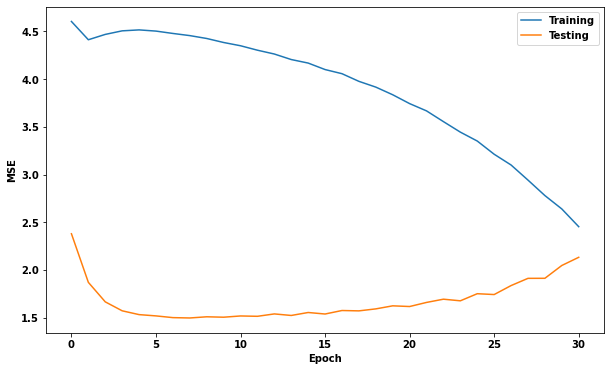

In [17]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data

In [18]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [19]:
# Section 2 : Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [20]:
# Section 3 : Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [21]:
# Examine the test data and forecast result 
print("Test Data \t Forecast Result")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

Test Data 	 Forecast Result
[484.99997]		[415.32822]
[505.]		[416.40164]
[525.]		[421.07996]
[545.]		[427.7832]
[565.]		[434.4864]
[585.]		[441.18964]


In [22]:
# Section 4 : Calculate the RMSE of train and test data
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 73.04 RMSE
Test Score: 111.77 RMSE


## Exercise for Multivariate input , Univariate Output (Solution)
Task : Predict total number of demand of orders (Target Total Orders)
Data Source : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Daily%20Demand%20Forecasting%20Orders

In [23]:
# First , we read the csv data using pandas library
demand = pd.read_csv(r"..\..\datasets\others\Daily_Demand_Forecasting_Orders.csv",sep=';')
demand.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [24]:
demand.insert(1,"Day",range(1,len(demand)+1))
demand
demand.set_index('Day')

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,,,
1,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
2,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
3,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
4,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
5,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
6,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364
7,2,5,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,48269,20973,263.043
8,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502,248.958
9,3,2,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458,344.291


In [25]:
demand_slice = demand.iloc[:,3::]
demand_slice.loc[1:5,:]

,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
1,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


In [26]:
# print the data shape to make sure we are correct slicing 
demand_value = demand_slice.values
demand_value.shape

(60, 11)

## Hyperparameter
Define the hyper parameter that need to tune the model

In [27]:
#Hyperameter
split_ratio_demand = 0.70
num_epochs_demand  = 500
window_size_demand = 4
n_step_demand = 1
learning_rate_demand = 0.01
batch_size_demand = 1
#seed
torch.manual_seed(123)

## Data Splitting

In [28]:
split_data_demand = round(len(dataset)*split_ratio)
split_data_demand

21

In [29]:
#split data by indexing 
train_data_demand = demand_value[:-split_data_demand]
test_data_demand = demand_value[-split_data_demand:]
train_time = demand.index[:-split_data_demand]
test_time = demand.index[-split_data_demand:]
print("train_data_shape")
print(train_data_demand.shape)
print("test_data_shape")
print(test_data_demand.shape)

train_data_shape
(39, 11)
test_data_shape
(21, 11)


## Data Normalization
The data is scaled to the range of -1 to 1 to standardize the data value

In [30]:
# Data Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized_demand  = scaler.fit_transform(train_data_demand.reshape(-1, 1))
test_data_normalized_demand = scaler.fit_transform(test_data_demand.reshape(-1, 1))

In [31]:
# Transform after scaling
train_data_normalized_demand = train_data_normalized_demand .reshape(train_data_demand.shape[0],train_data_demand.shape[1])
print("test_data_normalized"+str(train_data_normalized_demand.shape))

test_data_normalized_demand = test_data_normalized_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
print("test_data_normalized"+str(test_data_normalized_demand.shape))

test_data_normalized(39, 11)
test_data_normalized(21, 11)


## Data Seqeuncing

In [32]:
trainX_demand ,trainY_demand =  multivariate_univariate_single_step(train_data_normalized_demand,window_size_demand)
testX_demand , testY_demand = multivariate_univariate_single_step(test_data_normalized_demand,window_size_demand)
print(f"trainX_demand shape:{trainX_demand.shape} trainY_demand shape:{trainY_demand.shape}\n")
print(f"testX_demand shape:{testX_demand.shape} testX_demand shape:{testX_demand.shape}")

trainX_demand shape:(36, 4, 10) trainY_demand shape:(36,)

testX_demand shape:(18, 4, 10) testX_demand shape:(18, 4, 10)


## Data Transform

In [33]:
#  Data Transform

# make training and test sets in torch
trainX_demand = torch.from_numpy(trainX_demand).type(torch.Tensor)
trainY_demand = torch.from_numpy(trainY_demand).type(torch.Tensor)
testX_demand = torch.from_numpy(testX_demand).type(torch.Tensor)
testY_demand = torch.from_numpy(testY_demand).type(torch.Tensor)

#3D Data Preparation
trainX_demand = torch.reshape(trainX_demand,(trainX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],n_step_demand))
testX_demand = torch.reshape(testX_demand,(testX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],n_step_demand))



## Data Transpose

In [34]:
# trnaspose to suit CNN model
# Input: (N, C, L_in) in Conv1D
trainX_demand = torch.transpose(trainX_demand, 1, 2)
testX_demand = torch.transpose(testX_demand, 1, 2)

In [35]:
print(f"trainX_demand shape after transpose : {trainX_demand.shape}")
print(f"trainY_demand shape transpose : {trainY_demand.shape}")
print(f"testX_demand shape  transpose: {testX_demand.shape}")
print(f"testY_demand_demand shape transpose: {testY_demand.shape}")

trainX_demand shape after transpose : torch.Size([36, 10, 4])
trainY_demand shape transpose : torch.Size([36, 1])
testX_demand shape  transpose: torch.Size([18, 10, 4])
testY_demand_demand shape transpose: torch.Size([18, 1])


In [36]:
# trainX_demand=torch.unsqueeze(trainX_demand,1)
# testX_demand=torch.unsqueeze(testX_demand,1)
# print(f"After unsqueeze {trainX_demand.shape}")
# print(f"After unsqueeze {testX_demand.shape}")

## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [37]:
# Create Iterator
train_dataset_demand = TensorDataset(trainX_demand, trainY_demand)
train_iter_demand = DataLoader(train_dataset_demand,batch_size=batch_size_demand,shuffle=False)

test_dataset_demand = TensorDataset(testX_demand, testY_demand)
test_iter_demand = DataLoader(test_dataset_demand,batch_size=batch_size_demand,shuffle=False)

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [38]:
model_demand = CNN_Multivariate_Univariate(timeseries=trainX_demand.shape[1], n_step=n_step_demand)
print(model_demand.eval())
optimizer_demand = torch.optim.SGD(model_demand.parameters(), lr=learning_rate_demand)
loss_fn_demand = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(10, 10, kernel_size=(2,), stride=(1,), groups=10)
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(10, 10, kernel_size=(2,), stride=(1,), groups=10)
  (poo2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [39]:
# Start Training
train_loss_demand,val_loss_demand = training(num_epochs_demand,train_iter_demand,test_iter_demand,
                                           optimiser = optimizer_demand,
                                           loss_fn = loss_fn_demand,
                                            model=model_demand)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

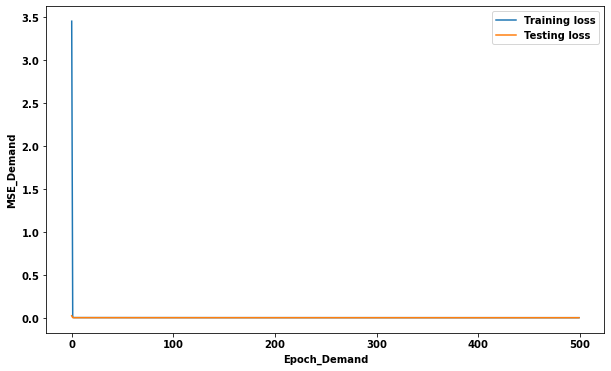

In [40]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand, label="Training loss")
plt.plot(val_loss_demand, label="Testing loss")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
plt.legend()
plt.show()

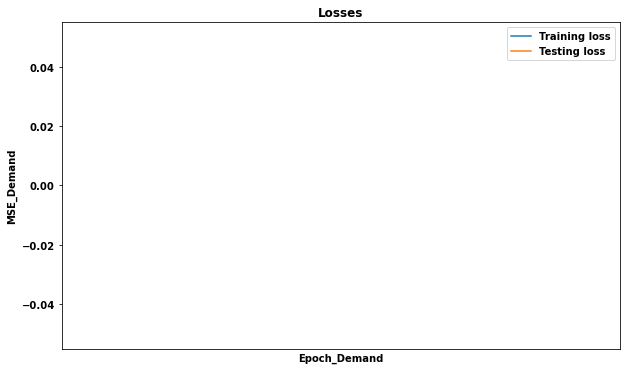

In [41]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 980
end_epoch = 100
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_demand[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data<br>

In [42]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction_demand = model_demand(trainX_demand)
    y_test_prediction_demand = model_demand(testX_demand)

# Section 2 : Reshape to original data
y_train_prediction_demand = torch.reshape(y_train_prediction_demand,(y_train_prediction_demand.shape[0],y_train_prediction_demand.shape[1]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],trainY_demand.shape[1]))
y_test_prediction_demand = torch.reshape(y_test_prediction_demand,(y_test_prediction_demand.shape[0],y_test_prediction_demand.shape[1]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],testY_demand.shape[1]))

In [43]:
# Section 3 : Invert predictions
y_train_prediction_demand = scaler.inverse_transform(y_train_prediction_demand.detach().numpy())
y_train_demand = scaler.inverse_transform(trainY_demand.detach().numpy())
y_test_prediction_demand = scaler.inverse_transform(y_test_prediction_demand.detach().numpy())
y_test_demand = scaler.inverse_transform(testY_demand.detach().numpy())

In [44]:
# Examine the test data and forecast result
print("Test Data \t\t Forecast Result")
for i in range(len(y_test_prediction_demand)):
    print(f"{y_test_demand[i]}\t\t{y_test_prediction_demand[i]}")

Test Data 		 Forecast Result
[234.50491]		[604.2422]
[234.7216]		[322.35355]
[230.06537]		[148.8836]
[357.39624]		[134.09856]
[259.24747]		[375.2401]
[244.23564]		[424.02475]
[402.6081]		[494.88116]
[255.05988]		[419.56]
[342.60614]		[-169.237]
[268.64056]		[201.89615]
[188.6027]		[405.24863]
[202.02213]		[83.585464]
[213.5065]		[-121.00163]
[316.85074]		[272.6064]
[286.41388]		[370.6746]
[303.4464]		[634.9915]
[304.9481]		[479.3402]
[331.89783]		[252.4042]


In [45]:
print(f"y_test_demand_shape : {y_test_demand.shape}")
print(f"y_test_demand_pred_shape : {y_test_prediction_demand.shape}")

y_test_demand_shape : (18, 1)
y_test_demand_pred_shape : (18, 1)


In [46]:
# calculate root mean squared error
trainScore_demand = math.sqrt(mean_squared_error(y_train_demand[:,0], y_train_prediction_demand[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_demand))
testScore_demand = math.sqrt(mean_squared_error(y_test_demand[:,0], y_test_prediction_demand[:,0]))
print('Test Score: %.2f RMSE' % (testScore_demand))

Train Score: 251.37 RMSE
Test Score: 220.76 RMSE


In [47]:
start_time =train_data_demand.shape[0]+window_size_demand
end_time = len(demand)+1

In [48]:
# Adjust to make the sequence data plot on original test data 
a=range(start_time,end_time)
a

range(43, 61)

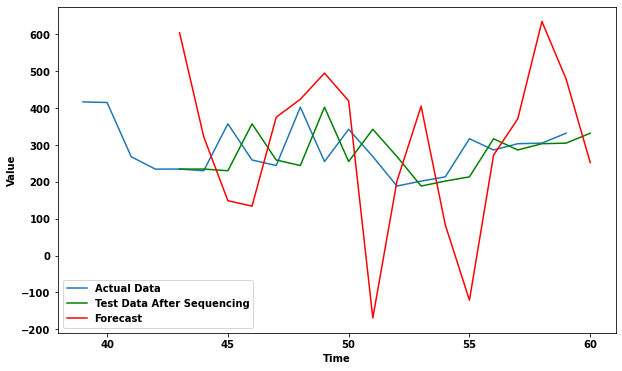

In [49]:
plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_demand[:,-1], label = 'Actual Data')
plt.plot(a,y_test_demand, color="green",label = 'Test Data After Sequencing')
plt.plot(a,y_test_prediction_demand,color="red", label = 'Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

##### ## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee